This is a generic script for finetuning ViLT model for VQA tasks
Simply format your data as per the requirements below and this should work.

## Data format
* the images (stored in a single folder)
* the questions (stored in a JSON) -- with following
* the annotations (stored in a JSON) a.k.a. the answers to the questions.

Refer to https://github.com/multimodal/multimodal/blob/master/test/data/vqa2/val/v2_OpenEnded_mscoco_val2014_questions.json for a sample of how question json file should look like.

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.5 MB/s eta 0:00:00


This piece of code converts data in VLQAv1 into desired format. If multiple images are there, it automatically merges them into one.

In [ ]:
prefix = 'blocksworld'

In [ ]:
from PIL import Image
import os

os.chdir('/content')

def mergeim(impath1,impath2):
  if impath1.endswith(".jpg"):
    postfix = ".jpg"
  elif impath1.endswith(".png"):
    postfix = ".png"
  else:
    print("no jpg or png file supplied")
  newname = 'Merged_'+impath1.split("/")[-1].rstrip(postfix) + "#"+ impath2.split("/")[-1].rstrip(postfix) + postfix
  #print(newname)
  image1 = Image.open(impath1)
  image2 = Image.open(impath2)
  image1_size = image1.size
  image2_size = image2.size
  new_image = Image.new('RGB',(2*image1_size[0], image1_size[1]), (250,250,250))
  new_image.paste(image1,(0,0))
  new_image.paste(image2,(image1_size[0],0))
  new_image.save("./images/"+newname)
  #new_image.show()
  return "./images/"+newname

mergeim('./images/BW_1_0.jpg','./images/BW_1_1.jpg')

'./images/Merged_BW_1_0#BW_1_1.jpg'

In [ ]:
#!rm /content/blocksworld_truncated_viltft.jsonl

import json
import ast

dumpdict = { "info": {}, "task_type": "Open-Ended", "data_type": "mscoco", "license": {}, "data_subtype": prefix,
    "questions": [] }

with open('/content/'+prefix+'.jsonl') as f:
  data = f.readlines()
  print(len(data))
  for i in data:
    ijson = json.loads(i)
    imlist = ast.literal_eval(ijson['images'])
    anslist = [str(i) for i in ast.literal_eval(ijson['answer_choices'])]
    if len(imlist) == 2:
      mpath = mergeim(imlist[0], imlist[1])
    dumpdict['questions'].append( { "image_id": mpath, "question": ijson['question']+" "+ijson['passage'], "question_id": ijson['qid'], "answer_choices": anslist, "answer_id": int(ijson['answer']) } )

with open('/content/'+prefix+'_viltft.jsonl','w+') as w:
  w.write(json.dumps(dumpdict,indent=4))

print(dumpdict)

250
{'info': {}, 'task_type': 'Open-Ended', 'data_type': 'mscoco', 'license': {}, 'data_subtype': 'blocksworld', 'questions': [{'image_id': './images/Merged_BW_1_0#BW_1_1.jpg', 'question': 'How many moves are required at minimum if configuration in image [0] is to be transformed into configuration in image [1]? Consider 6 blocks of colors [Red, Green, Purple, Orange, Yellow and Blue]. Blocks can be moved as per three conditions below. A block can be moved if there is no other block on it. At each time stamp only one block can be moved. A block can be moved OnTable, OutOfTable or on any other block.', 'question_id': 0, 'answer_choices': ['1', '5', '2', '3'], 'answer_id': 0}, {'image_id': './images/Merged_BW_2_0#BW_2_1.jpg', 'question': 'How many moves are required at minimum if configuration in image [0] is to be transformed into configuration in image [1]? Consider 6 blocks of colors [Red, Green, Purple, Orange, Yellow and Blue]. Blocks can be moved as per three conditions below. A blo

### Read questions

First, we read the questions.

In [ ]:
import json
f = open('/content/'+prefix+'_viltft.jsonl','r')
data_questions = json.load(f)
questions = data_questions['questions']

print(data_questions.keys())
print("Number of questions:", len(questions))

dict_keys(['info', 'task_type', 'data_type', 'license', 'data_subtype', 'questions'])
Number of questions: 250


That's quite a lot! Let's take a look at the first one:

In [ ]:
questions[0]

{'image_id': './images/Merged_BW_1_0#BW_1_1.jpg',
 'question': 'How many moves are required at minimum if configuration in image [0] is to be transformed into configuration in image [1]? Consider 6 blocks of colors [Red, Green, Purple, Orange, Yellow and Blue]. Blocks can be moved as per three conditions below. A block can be moved if there is no other block on it. At each time stamp only one block can be moved. A block can be moved OnTable, OutOfTable or on any other block.',
 'question_id': 0,
 'answer_choices': ['1', '5', '2', '3'],
 'answer_id': 0}

In [ ]:
from os import listdir
from os.path import isfile, join

# -- CHANGE THIS BASED ON WHERE IMAGES ARE STORED --
root = '/content/images'

file_names = [f for f in listdir(root) if isfile(join(root, f))]
print(file_names)
print(len(file_names))

['BW_33_1.jpg', 'BW_90_0.jpg', 'BW_75_1.jpg', 'BW_69_1.jpg', 'BW_91_1.jpg', 'BW_76_1.jpg', 'BW_61_1.jpg', 'BW_44_1.jpg', 'BW_48_1.jpg', 'BW_26_0.jpg', 'Merged_BW_69_0#BW_69_1.jpg', 'Merged_BW_86_0#BW_86_1.jpg', 'BW_87_0.jpg', 'Merged_BW_38_0#BW_38_1.jpg', 'BW_11_1.jpg', 'Merged_BW_96_0#BW_96_1.jpg', 'BW_91_0.jpg', 'Merged_BW_30_0#BW_30_1.jpg', 'BW_49_1.jpg', 'Merged_BW_99_0#BW_99_1.jpg', 'Merged_BW_10_0#BW_10_1.jpg', 'BW_24_1.jpg', 'BW_79_0.jpg', 'BW_57_0.jpg', 'BW_74_0.jpg', 'Merged_BW_91_0#BW_91_1.jpg', 'BW_44_0.jpg', 'BW_54_1.jpg', 'BW_68_1.jpg', 'BW_70_0.jpg', 'BW_93_1.jpg', 'Merged_BW_88_0#BW_88_1.jpg', 'Merged_BW_3_0#BW_3_1.jpg', 'Merged_BW_34_0#BW_34_1.jpg', 'Merged_BW_68_0#BW_68_1.jpg', 'Merged_BW_42_0#BW_42_1.jpg', 'BW_80_0.jpg', 'Merged_BW_67_0#BW_67_1.jpg', 'Merged_BW_80_0#BW_80_1.jpg', 'BW_89_1.jpg', 'BW_9_1.jpg', 'Merged_BW_56_0#BW_56_1.jpg', 'BW_65_1.jpg', 'BW_25_1.jpg', 'BW_43_0.jpg', 'BW_33_0.jpg', 'BW_6_0.jpg', 'BW_34_1.jpg', 'Merged_BW_20_0#BW_20_1.jpg', 'BW_10_1.jpg'

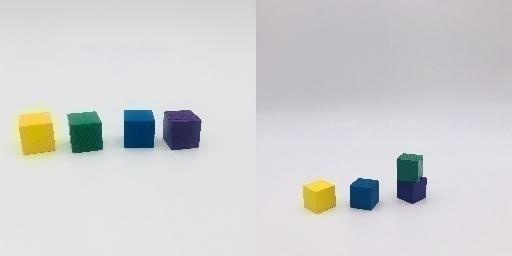

In [ ]:
from PIL import Image

path = questions[0]['image_id']
image = Image.open(path)
image

In [ ]:
from transformers import ViltConfig

config = ViltConfig.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

## Create PyTorch dataset

Next, we create a regular [PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). We leverage `ViltProcessor` to prepare each image + text pair for the model, which will automatically:
* leverage `BertTokenizerFast` to tokenize the text and create `input_ids`, `attention_mask` and `token_type_ids`
* leverage `ViltFeatureExtractor` to resize + normalize the image and create `pixel_values` and `pixel_mask`.

Note that the docs of `ViltProcessor` can be found [here](https://huggingface.co/docs/transformers/master/en/model_doc/vilt#transformers.ViltProcessor).

We also add the labels. This is a PyTorch tensor of shape `(num_labels,)` that contains the soft encoded vector.

In [ ]:
import torch
from PIL import Image

class VQADataset(torch.utils.data.Dataset):

    def __init__(self, questions, processor): #annotations
        self.questions = questions
        #self.annotations = annotations
        self.processor = processor

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        # get image + text
        #annotation = self.annotations[idx]
        questions = self.questions[idx]
        #image = Image.open(id_to_filename[annotation['image_id']])
        image = Image.open(questions['image_id'])
        text = questions['question']
        #print(image)
        #print(text)
        encoding = self.processor(image, text, padding="max_length", truncation=True, return_tensors="pt")
        # remove batch dimension
        for k,v in encoding.items():
          encoding[k] = v.squeeze()
        # add labels
        #labels = questions['answer_choices'][questions['answer_id']] #annotation['labels']
        #scores = [1.0] #annotation['scores']
        # based on: https://github.com/dandelin/ViLT/blob/762fd3975c180db6fc88f577cf39549983fa373a/vilt/modules/objectives.py#L301
        #print(len(questions['answer_choices']))
        targets = torch.zeros(len(questions['answer_choices']))
        targets[questions['answer_id']] = 1.0
        #print(targets)
        #for label, score in zip(labels, scores):
        #      targets[label] = score
        encoding["labels"] = targets
        #print(encoding)
        #print(labels)
        #print(scores)

        return encoding

In [ ]:
from transformers import ViltProcessor

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")

In [ ]:
# 4wT
dataset = VQADataset(questions=questions[:100],processor=processor) ##annotations=annotations[:10],
# 4wS

# Bin

In [ ]:
dataset[1].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'])

In [ ]:
processor.decode(dataset[0]['input_ids'])

'[CLS] how many moves are required at minimum if configuration in image [ 0 ] is to be transformed into configuration in image [ 1 ]? consider 6 blocks of colors [ red, green, purple, [SEP]'

In [ ]:
labels = torch.nonzero(dataset[0]['labels']).squeeze().tolist()

## Define model

Here we define a `ViltForQuestionAnswering` model, with the weights of the body initialized from dandelin/vilt-b32-mlm, and a randomly initialized classification head. We also move it to the GPU, if it's available.

In [ ]:
from transformers import ViltForQuestionAnswering

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-mlm", num_labels=4)
                                                 #len(config.id2label))
                                                 #id2label=config.id2label,
                                                 #label2id=config.label2id)
model.to(device)

Some weights of ViltForQuestionAnswering were not initialized from the model checkpoint at dandelin/vilt-b32-mlm and are newly initialized: ['classifier.0.bias', 'classifier.3.bias', 'classifier.1.weight', 'classifier.0.weight', 'classifier.1.bias', 'classifier.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViltForQuestionAnswering(
  (vilt): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(40, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(2, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=76

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  input_ids = [item['input_ids'] for item in batch]
  pixel_values = [item['pixel_values'] for item in batch]
  #print(pixel_values)
  attention_mask = [item['attention_mask'] for item in batch]
  token_type_ids = [item['token_type_ids'] for item in batch]
  labels = [item['labels'] for item in batch]

  # create padded pixel values and corresponding pixel mask
  #encoding = processor.feature_extractor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")

  # create new batch
  batch = {}
  batch['input_ids'] = torch.stack(input_ids)
  batch['attention_mask'] = torch.stack(attention_mask)
  batch['token_type_ids'] = torch.stack(token_type_ids)
  batch['pixel_values'] = torch.stack(pixel_values) #encoding['pixel_values']
  #batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = torch.stack(labels)

  return batch

train_dataloader = DataLoader(dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)

Let's verify a batch:

In [ ]:
batch = next(iter(train_dataloader))

In [ ]:
for k,v in batch.items():
  print(k, v.shape)

input_ids torch.Size([1, 40])
attention_mask torch.Size([1, 40])
token_type_ids torch.Size([1, 40])
pixel_values torch.Size([1, 3, 320, 608])
labels torch.Size([1, 4])


## Train a model

Finally, let's train a model!

In [ ]:
from tqdm.notebook import tqdm
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# -- CHANGE BASED ON HOW MANY EPOCHS YOU WANT TO RUN FOR
e = 5

model.train()
for epoch in range(e):  # loop over the dataset multiple times
   print(f"Epoch: {epoch}")
   for batch in tqdm(train_dataloader):
        # get the inputs;
        batch = {k:v.to(device) for k,v in batch.items()}

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        print("Loss:", loss.item())
        loss.backward()
        optimizer.step()

Epoch: 0


  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 2.4489099979400635
Loss: 3.195952892303467
Loss: 2.563725471496582
Loss: 2.51505184173584
Loss: 3.9789679050445557
Loss: 3.4941725730895996
Loss: 2.5954208374023438
Loss: 1.9021531343460083
Loss: 2.299018621444702
Loss: 2.3586349487304688
Loss: 3.191650867462158
Loss: 3.0141193866729736
Loss: 2.3296215534210205
Loss: 1.810861587524414
Loss: 2.984464645385742
Loss: 1.8572769165039062
Loss: 1.855180025100708
Loss: 1.6034729480743408
Loss: 2.6252946853637695
Loss: 1.7585140466690063
Loss: 4.013866424560547
Loss: 4.005318641662598
Loss: 1.9859967231750488
Loss: 2.972996950149536
Loss: 2.7680938243865967
Loss: 3.4352831840515137
Loss: 1.8663321733474731
Loss: 1.823449730873108
Loss: 2.2109134197235107
Loss: 2.19669246673584
Loss: 1.4730894565582275
Loss: 2.401029348373413
Loss: 4.681848049163818
Loss: 2.895798683166504
Loss: 2.7614786624908447
Loss: 2.511091709136963
Loss: 2.142792224884033
Loss: 2.02533221244812
Loss: 2.825084924697876
Loss: 1.6295721530914307
Loss: 1.420454382896423

  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 2.0051639080047607
Loss: 1.8742207288742065
Loss: 2.448802947998047
Loss: 2.833406448364258
Loss: 1.2661641836166382
Loss: 2.227379560470581
Loss: 1.2972443103790283
Loss: 3.03122615814209
Loss: 2.6562957763671875
Loss: 2.434063196182251
Loss: 2.399914503097534
Loss: 4.137792110443115
Loss: 2.2184524536132812
Loss: 1.958953857421875
Loss: 2.063131332397461
Loss: 2.0046048164367676
Loss: 1.7921139001846313
Loss: 1.7218538522720337
Loss: 2.920175552368164
Loss: 1.9636784791946411
Loss: 3.116410493850708
Loss: 1.8788731098175049
Loss: 1.7499417066574097
Loss: 2.6533641815185547
Loss: 2.6435210704803467
Loss: 1.9248206615447998
Loss: 1.7997199296951294
Loss: 4.029171943664551
Loss: 2.040001630783081
Loss: 2.3806304931640625
Loss: 3.8231699466705322
Loss: 1.6573843955993652
Loss: 2.1034529209136963
Loss: 1.5396474599838257
Loss: 1.533005952835083
Loss: 1.4266961812973022
Loss: 2.9777674674987793
Loss: 3.357165813446045
Loss: 2.5403337478637695
Loss: 3.134481191635132
Loss: 2.674595594

  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.5954718589782715
Loss: 2.837993621826172
Loss: 2.632687568664551
Loss: 2.9796502590179443
Loss: 1.950494408607483
Loss: 2.6253960132598877
Loss: 2.576725959777832
Loss: 2.3478035926818848
Loss: 2.495743751525879
Loss: 2.5231692790985107
Loss: 2.3853087425231934
Loss: 3.2034449577331543
Loss: 1.907752275466919
Loss: 2.9399445056915283
Loss: 1.8854038715362549
Loss: 1.7637269496917725
Loss: 2.9827263355255127
Loss: 2.1873865127563477
Loss: 1.4847291707992554
Loss: 2.728832483291626
Loss: 2.5646862983703613
Loss: 2.4471724033355713
Loss: 2.3420252799987793
Loss: 3.8134071826934814
Loss: 1.9410934448242188
Loss: 3.736104726791382
Loss: 1.7207162380218506
Loss: 1.5849077701568604
Loss: 2.883737325668335
Loss: 2.9840080738067627
Loss: 2.940519094467163
Loss: 2.560699462890625
Loss: 2.6494550704956055
Loss: 2.411567211151123
Loss: 2.6413280963897705
Loss: 1.7213329076766968
Loss: 3.3281142711639404
Loss: 1.7163712978363037
Loss: 2.06891131401062
Loss: 2.723073959350586
Loss: 3.1899306

  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 2.3358631134033203
Loss: 1.6373690366744995
Loss: 2.7211198806762695
Loss: 2.816699266433716
Loss: 2.6870155334472656
Loss: 2.738596200942993
Loss: 2.5586159229278564
Loss: 2.5792338848114014
Loss: 2.470590114593506
Loss: 2.3165977001190186
Loss: 2.2272136211395264
Loss: 2.097723960876465
Loss: 2.6444497108459473
Loss: 2.129307746887207
Loss: 2.8057861328125
Loss: 2.840350389480591
Loss: 2.7553677558898926
Loss: 2.8016560077667236
Loss: 2.7758591175079346
Loss: 2.110013484954834
Loss: 2.7042739391326904
Loss: 2.5914716720581055
Loss: 2.5038774013519287
Loss: 2.3971147537231445
Loss: 2.0473320484161377
Loss: 2.5727179050445557
Loss: 2.316199779510498
Loss: 2.511380434036255
Loss: 2.276942253112793
Loss: 1.9438844919204712
Loss: 1.8794400691986084
Loss: 2.527111291885376
Loss: 2.548492431640625
Loss: 2.3934361934661865
Loss: 2.364778518676758
Loss: 2.483689069747925
Loss: 2.7034730911254883
Loss: 2.225649118423462
Loss: 2.153650999069214
Loss: 1.9473097324371338
Loss: 2.37489867210

  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 1.8370380401611328
Loss: 1.7302507162094116
Loss: 2.7393553256988525
Loss: 3.502978801727295
Loss: 1.521340250968933
Loss: 1.453944206237793
Loss: 3.497044801712036
Loss: 2.469202995300293
Loss: 2.637232780456543
Loss: 2.566115379333496
Loss: 2.579169988632202
Loss: 2.529635190963745
Loss: 2.5547983646392822
Loss: 2.4614944458007812
Loss: 1.5048311948776245
Loss: 1.550707459449768
Loss: 1.5725383758544922
Loss: 2.3778929710388184
Loss: 2.2424137592315674
Loss: 1.605853796005249
Loss: 2.208796262741089
Loss: 3.4522461891174316
Loss: 3.4557690620422363
Loss: 2.3981430530548096
Loss: 3.2879068851470947
Loss: 2.3849055767059326
Loss: 1.849438190460205
Loss: 3.049257278442383
Loss: 2.296194076538086
Loss: 1.96653151512146
Loss: 2.7501378059387207
Loss: 2.0085787773132324
Loss: 2.270056962966919
Loss: 2.209465503692627
Loss: 2.457289218902588
Loss: 2.3760926723480225
Loss: 2.4100561141967773
Loss: 2.209914445877075
Loss: 2.436411142349243
Loss: 2.2919106483459473
Loss: 2.08236122131347

## Inference

Let's verify whether the model has actually learned something:

# Single Instance Inference

In [ ]:
exid = 1
example = dataset[exid]
print(example.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'])


In [ ]:
# add batch dimension + move to GPU
example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}

# forward pass
outputs = model(**example)

In [ ]:
logits = outputs.logits
predicted_class = logits.argmax(-1).item()
print("Predicted answer:", predicted_class)
print("Ground-truth answer:", dataset[exid]['labels'].argmax(-1).item())

Predicted answer: 0
Ground-truth answer: 3


# Batch Inference

In [ ]:
import csv
tasktype = "4wt"
filprefix = prefix+"_"+tasktype

# Accuracy of 4wT blocksworld data truncated - finetuned by ViLT
count = 0
st = 0
end = 99
with open(filprefix+'.csv', 'w+') as k:
  spamwriter = csv.writer(k)
  spamwriter.writerow(["qid","pred_ans","gt_ans","correctness"])
  for exid in range(st,end+1):
    correctness = 0
    example = dataset[exid]
    example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}
    outputs = model(**example)
    logits = outputs.logits
    predicted_class = logits.argmax(-1).item()
    gtclass = dataset[exid]['labels'].argmax(-1).item()
    if gtclass==predicted_class:
      count+=1
      correctness = 1
    print([exid,predicted_class, gtclass,correctness])
    spamwriter.writerow([exid,predicted_class, gtclass,correctness])
acc = count*100/(end-st+1)

print(count)
print(end-st+1)
print(acc)

[0, 2, 0, 0]
[1, 2, 3, 0]
[2, 2, 0, 0]
[3, 2, 0, 0]
[4, 2, 0, 0]
[5, 2, 0, 0]
[6, 2, 0, 0]
[7, 2, 2, 1]
[8, 2, 3, 0]
[9, 2, 3, 0]
[10, 2, 0, 0]
[11, 2, 2, 1]
[12, 2, 3, 0]
[13, 2, 1, 0]
[14, 2, 1, 0]
[15, 2, 1, 0]
[16, 2, 2, 1]
[17, 2, 0, 0]
[18, 2, 2, 1]
[19, 2, 3, 0]
[20, 2, 1, 0]
[21, 2, 0, 0]
[22, 2, 0, 0]
[23, 2, 3, 0]
[24, 2, 2, 1]
[25, 2, 2, 1]
[26, 2, 1, 0]
[27, 2, 3, 0]
[28, 2, 3, 0]
[29, 2, 2, 1]
[30, 2, 0, 0]
[31, 2, 3, 0]
[32, 2, 2, 1]
[33, 2, 0, 0]
[34, 2, 1, 0]
[35, 2, 0, 0]
[36, 2, 2, 1]
[37, 2, 0, 0]
[38, 2, 3, 0]
[39, 2, 1, 0]
[40, 0, 1, 0]
[41, 0, 2, 0]
[42, 0, 2, 0]
[43, 0, 3, 0]
[44, 0, 0, 1]
[45, 0, 2, 0]
[46, 0, 2, 0]
[47, 0, 1, 0]
[48, 0, 2, 0]
[49, 0, 1, 0]
[50, 0, 2, 0]
[51, 0, 3, 0]
[52, 0, 1, 0]
[53, 0, 2, 0]
[54, 0, 0, 1]
[55, 0, 3, 0]
[56, 0, 0, 1]
[57, 0, 3, 0]
[58, 0, 0, 1]
[59, 0, 2, 0]
[60, 0, 2, 0]
[61, 0, 0, 1]
[62, 0, 3, 0]
[63, 0, 0, 1]
[64, 0, 1, 0]
[65, 0, 2, 0]
[66, 0, 0, 1]
[67, 0, 3, 0]
[68, 0, 0, 1]
[69, 0, 1, 0]
[70, 0, 3, 0]
[71, 0, 3, 0]
[7

In [ ]:
import csv
tasktype = "4wt"
filprefix = prefix+"_"+tasktype

# Accuracy of 4wT blocksworld data original - finetuned by ViLT
count = 0
st = 0
end = 99
with open(filprefix+'.csv', 'w+') as k:
  spamwriter = csv.writer(k)
  spamwriter.writerow(["qid","pred_ans","gt_ans","correctness"])
  for exid in range(st,end+1):
    correctness = 0
    example = dataset[exid]
    example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}
    outputs = model(**example)
    logits = outputs.logits
    predicted_class = logits.argmax(-1).item()
    gtclass = dataset[exid]['labels'].argmax(-1).item()
    if gtclass==predicted_class:
      count+=1
      correctness = 1
    print([exid,predicted_class, gtclass,correctness])
    spamwriter.writerow([exid,predicted_class, gtclass,correctness])
acc = count*100/(end-st+1)

print(count)
print(end-st+1)
print(acc)

[0, 2, 0, 0]
[1, 2, 3, 0]
[2, 2, 0, 0]
[3, 2, 0, 0]
[4, 2, 0, 0]
[5, 2, 0, 0]
[6, 2, 0, 0]
[7, 2, 2, 1]
[8, 2, 3, 0]
[9, 2, 3, 0]
[10, 2, 0, 0]
[11, 2, 2, 1]
[12, 2, 3, 0]
[13, 2, 1, 0]
[14, 2, 1, 0]
[15, 2, 1, 0]
[16, 2, 2, 1]
[17, 2, 0, 0]
[18, 2, 2, 1]
[19, 2, 3, 0]
[20, 2, 1, 0]
[21, 2, 0, 0]
[22, 2, 0, 0]
[23, 2, 3, 0]
[24, 2, 2, 1]
[25, 2, 2, 1]
[26, 2, 1, 0]
[27, 2, 3, 0]
[28, 2, 3, 0]
[29, 2, 2, 1]
[30, 2, 0, 0]
[31, 2, 3, 0]
[32, 2, 2, 1]
[33, 2, 0, 0]
[34, 2, 1, 0]
[35, 2, 0, 0]
[36, 2, 2, 1]
[37, 2, 0, 0]
[38, 2, 3, 0]
[39, 2, 1, 0]
[40, 2, 1, 0]
[41, 2, 2, 1]
[42, 2, 2, 1]
[43, 2, 3, 0]
[44, 2, 0, 0]
[45, 2, 2, 1]
[46, 2, 2, 1]
[47, 2, 1, 0]
[48, 2, 2, 1]
[49, 2, 1, 0]
[50, 2, 2, 1]
[51, 2, 3, 0]
[52, 2, 1, 0]
[53, 2, 2, 1]
[54, 2, 0, 0]
[55, 2, 3, 0]
[56, 2, 0, 0]
[57, 2, 3, 0]
[58, 2, 0, 0]
[59, 2, 2, 1]
[60, 2, 2, 1]
[61, 2, 0, 0]
[62, 2, 3, 0]
[63, 2, 0, 0]
[64, 2, 1, 0]
[65, 2, 2, 1]
[66, 2, 0, 0]
[67, 2, 3, 0]
[68, 2, 0, 0]
[69, 2, 1, 0]
[70, 2, 3, 0]
[71, 2, 3, 0]
[7